In [6]:
#for local
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [11]:
%load_ext autoreload
%autoreload 2
import importlib
import math, random, copy, numpy as np
import cProfile
import yaml
from generator import MCTS
from language import Language
from node import MolSentenceNode
from utils import class_from_package, HELMConverter

config_path = "config/mcts_helm.yaml"
with open(repo_root + config_path) as f:
    conf = yaml.safe_load(f)
    
model_class, model_dir, lang_path = (conf.get(k) for k in ("model_class", "model_dir", "lang_path"))
lang = Language.load(repo_root + lang_path)
model_class = class_from_package("transition", model_class)
model = model_class(lang=lang, model_dir=repo_root + model_dir)

reward_class, reward_conf = (conf.get(k) for k in ("reward_class", "reward_conf"))
reward_class = class_from_package("reward", reward_class)
reward = reward_class(**reward_conf)

policy_class_path, policy_conf = (conf.get(k) for k in ("policy_class", "policy_conf"))
policy_class = class_from_package("policy", policy_class_path)
policy = policy_class(**policy_conf)

filter_settings = conf.get("filters", [])
filters = []
for s in filter_settings:
    filter_class = class_from_package("filter", s.pop("filter_class"))
    filters.append(filter_class(**s))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Search is started.
0- time: 0.05, count_rollouts: 2, reward: -0.9304694700436734, node: PEPTIDE1{[ac].L.R.R.Q.R.I.I.R.F.R.R.F.G.G.S.F.L.G.[am]}$$$$
1- time: 0.09, count_rollouts: 3, reward: -0.46953393800228943, node: PEPTIDE1{[ac].D.D.I.V.P.C}$$$$
2- time: 0.10, count_rollouts: 4, reward: 0.902886833788492, node: PEPTIDE1{R.A.A.E.C.G.A.K.Q.R.V.R}$$$$
3- time: 0.13, count_rollouts: 5, reward: -0.8840130335515616, node: PEPTIDE1{R.P.K.[dP].[dQ].Q.[dF].F.G.L.M.[am]}$$$$
4- time: 0.15, count_rollouts: 6, reward: -0.9067999293355271, node: PEPTIDE1{Y.G.S.F.L.R.R.I.R.P.K.L.K.[am]}$$$$
5- time: 0.18, count_rollouts: 7, reward: -0.8341918848206668, node: PEPTIDE1{G.R.R.K.H.V.I.R.K}$$$$
6- time: 0.20, count_rollouts: 8, reward: -0.9366524384563784, node: PEPTIDE1{F.D.G.F.T.G.A.R.K.S.A.R.K.L.A.N.Q}$$$$
7- time: 0.23, count_rollouts: 9, reward: 0.9445035246945701, node: PEPTIDE1{A.A.G.A.[am]}$$$$
8- time: 0.27, count_rollouts: 11, reward: -0.7441321384313738, node: PEPTIDE1{T.A.V.F.P}$$$$
9- tim

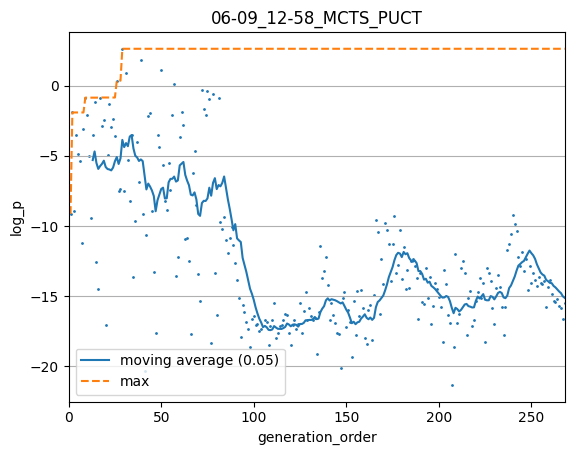

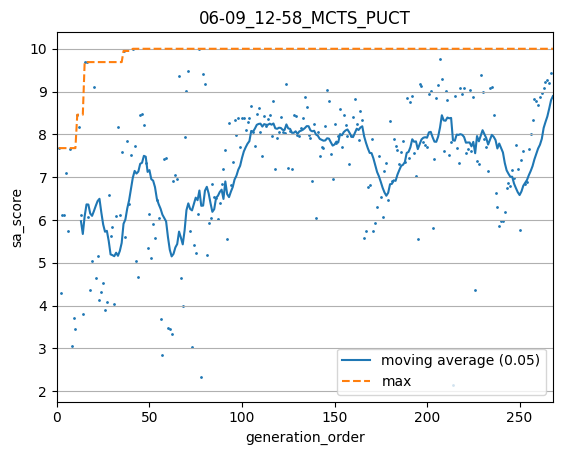

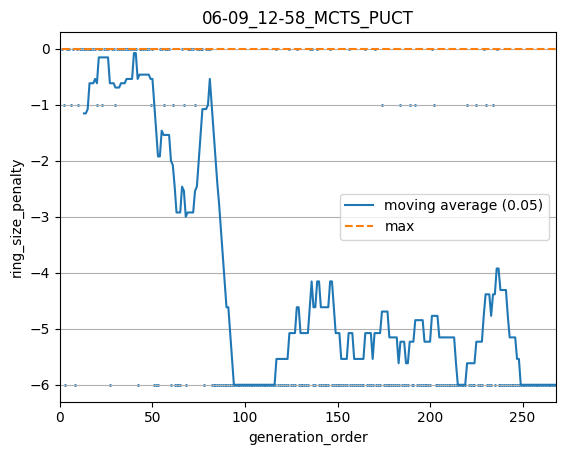

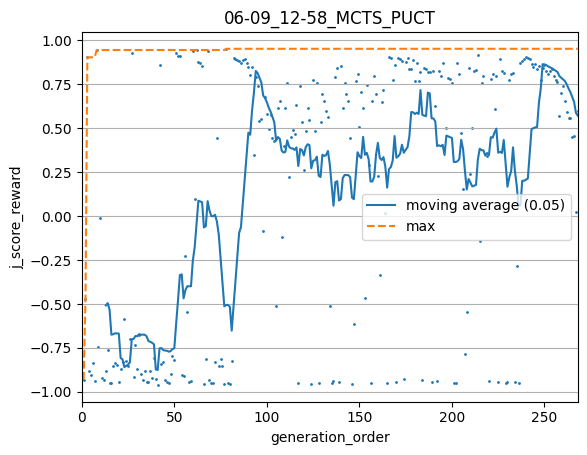

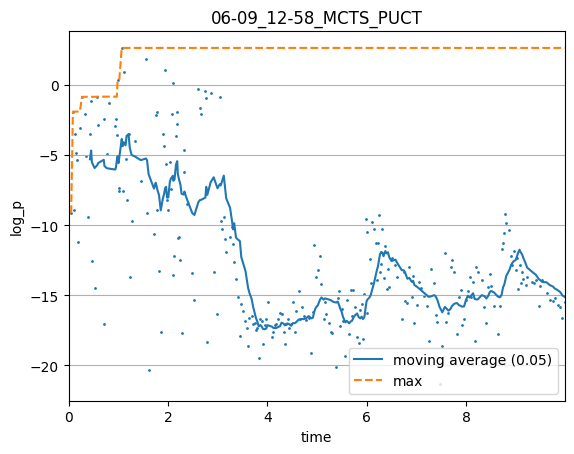

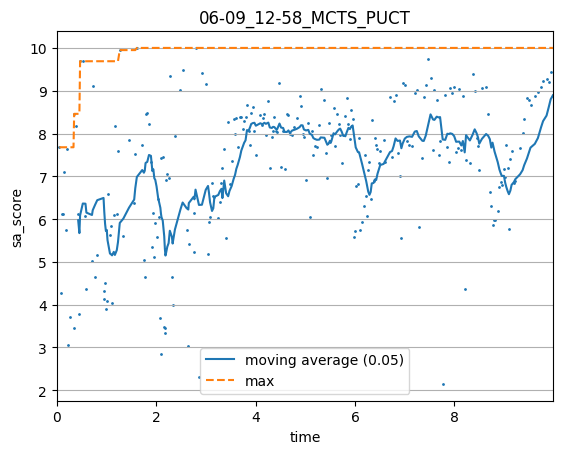

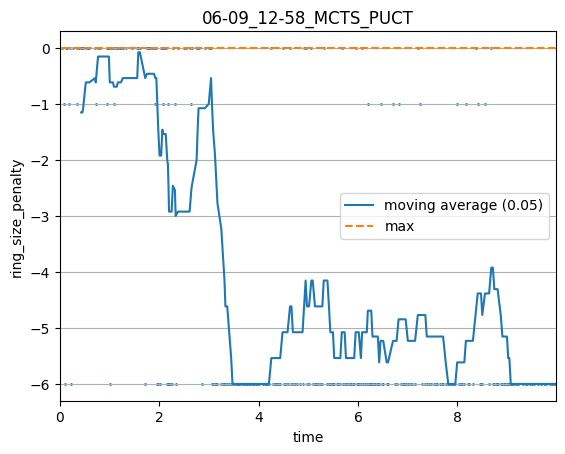

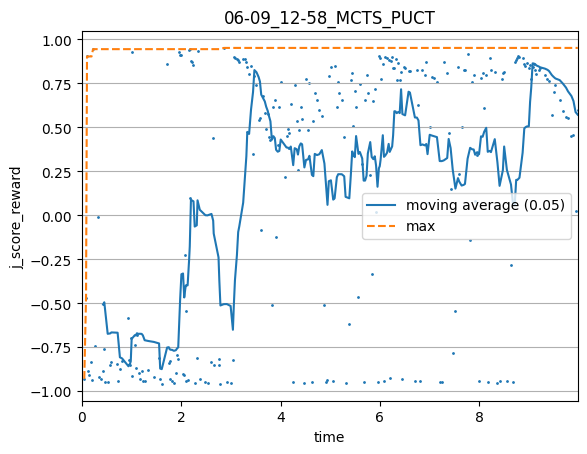

In [12]:
from rdkit import RDLogger
import shutil

RDLogger.DisableLog('rdApp.*') #invalid mols are already logged

root = MolSentenceNode.bos_node(lang) #TODO: change after root node generalization

output_dir, generation_conf = (conf.get(k) for k in ("output_dir", "generation_conf"))
generator = MCTS(transition=model, reward=reward, policy=policy, filters=filters, output_dir=output_dir)
src = repo_root + config_path
dst = generator.output_dir() + "setting.yaml"
shutil.copy(src, dst)

generator.generate(root=root, **generation_conf)
#cProfile.run("generator.generate(root=root, **generation_conf)"")

generator.plot_objective_values_and_reward(x_axis = "generation_order")
generator.plot_objective_values_and_reward(x_axis = "time")

In [7]:
#save mcts
save_path = generator.output_dir() + "test.mcts"
generator.save(save_path)

In [ ]:
#load mcts
generator = MCTS.load(save_path, model)